In [3]:
!pip install transformers==4.28.0
!pip install git+https://github.com/huggingface/accelerate
!pip install wandb
import wandb
import pandas as pd
import torch
import numpy as np
import random
import re
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from google.colab import drive

from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline

from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score


from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EvalPrediction


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-h2dh2s8u
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-h2dh2s8u
  Resolved https://github.com/huggingface/accelerate to commit b76409ba05e6fa7dfc59d50eee1734672126fdba
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
drive.mount('/content/gdrive')

test= pd.read_csv('/content/gdrive/My Drive/crypto/crypto_news_parsed_2013-2017_train.csv')
test.dtypes
test
train = pd.read_csv('/content/gdrive/My Drive/crypto/cryptonews.csv')
train.dtypes
train

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,date,sentiment,source,subject,text,title,url
0,2022-11-15 11:00:28,"{'class': 'positive', 'polarity': 0.17, 'subje...",CoinTelegraph,blockchain,With a roster full of entertainment industry n...,Aether Games Sets Sights on Dark Fantasy DeFi ...,https://cointelegraph.com/news/aether-games-se...
1,2022-11-15 10:55:04,"{'class': 'negative', 'polarity': -0.07, 'subj...",CoinTelegraph,bitcoin,Blockchain analytics firm Nansen has released ...,FTX debacle sees Nansen take stock of major ex...,https://cointelegraph.com/news/ftx-debacle-see...
2,2022-11-15 10:32:04,"{'class': 'positive', 'polarity': 0.05, 'subje...",CoinTelegraph,bitcoin,The hardware wallet firm is certain that the l...,Trezor reports 300% surge in sales revenue due...,https://cointelegraph.com/news/trezor-reports-...
3,2022-11-15 09:56:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"Kyle Davies, founder of the collapsed crypto f...",Defunct Billion-Dollar Crypto Hedge Fund Three...,https://cryptonews.com/news/defunct-billion-do...
4,2022-11-15 09:46:00,"{'class': 'positive', 'polarity': 0.11, 'subje...",CryptoNews,blockchain,Despite the ongoing crypto market downturn whi...,Billionaire Mark Cuban Still Believes in Crypt...,https://cryptonews.com/news/billionaire-mark-c...
...,...,...,...,...,...,...,...
12745,2021-10-27 15:17:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,defi,Cream Finance (CREAM) suffered another flash l...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...
12746,2021-10-19 13:39:00,"{'class': 'positive', 'polarity': 0.1, 'subjec...",CryptoNews,blockchain,Banque de France disclosed the results of its ...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...
12747,2021-10-18 13:58:00,"{'class': 'positive', 'polarity': 0.14, 'subje...",CryptoNews,blockchain,Advancing its project to become \x9caÂ\xa0meta...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...
12748,2021-10-15 00:00:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,Chinese companies are still topping the blockc...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...


In [5]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

In [24]:
train['sentiment']
len(train)

train['target'] = 0
for i in tqdm (range(0, len(train))):
  c=train['sentiment'][i]
  c = re.findall(r'\w+', c)
  train['target'][i] = c[1]
train


In [25]:
X = train['text']
y = train['sentiment']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)

In [26]:
train_df = pd.DataFrame({'text': X_train, 'label': y_train}).astype('str')
train_labels = train_df['label']
test_df = pd.DataFrame({'text': X_test, 'label': y_test}).astype('str')
test_labels = test_df['label']
val_df = pd.DataFrame({'text': X_val, 'label': y_val})
val_labels = val_df['label']


In [27]:
test_df['label'] = test_df['label'].replace({'negative':0, 'neutral':1, 'positive':2})
train_df['label'] = train_df['label'].replace({'negative':0, 'neutral':1, 'positive':2})
val_df['label'] = val_df['label'].replace({'negative':0, 'neutral':1, 'positive':2})

train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

test_df


,text,label
0,The Japanese digital asset exchange Gaia will ...,1
1,A Finder.com panel predicted that ADA could re...,2
2,The latest big name to get involved in the NFT...,2
3,STRAX price bucked the market-wide bearish dow...,2
4,'This deal continues to be a rollercoaster.',1
...,...,...
2545,Listen to what Polygon's Co-founder and COO Sa...,2
2546,42% of the poll participants said they don't i...,1
2547,Police in the Bahamas has launched an investig...,0
2548,Developers have seven days to fix the associat...,1


In [28]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

In [29]:
tokens_train = tokenizer.batch_encode_plus(
    train_df['text'].values,
    max_length = 512,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    test_df['text'].values,
    max_length = 512,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    val_df['text'].values,
    padding='max_length',
    max_length=512,
    truncation=True
)

In [30]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = Data(tokens_train, train_labels)
test_dataset = Data(tokens_test, test_labels)
val_dataset = Data(tokens_val, val_labels)

In [31]:
training_args = TrainingArguments(
    optim='adamw_torch',
    output_dir = './results', #Выходной каталог
    num_train_epochs = 3, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер пакета для каждого устройства во время валидации
    weight_decay =0.01, #Понижение весов
    logging_dir = './logs', #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 1e-5, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

In [35]:
from sklearn.metrics import f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    return {'F1': f1}

In [36]:
trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics = compute_metrics)

In [ ]:
trainer.train()

In [110]:
wandb.finish()

eval/accuracy,▁▆█
eval/f1,▁▇█
eval/loss,█▁▄
eval/roc_auc,▁▇█
eval/runtime,▄▁█
eval/samples_per_second,▅█▁
eval/steps_per_second,▅█▁
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/learning_rate,█▅▁
train/loss,█▃▁


In [ ]:
trainer.save_model("bert_kursach")

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert_kursach')
model = BertForSequenceClassification.from_pretrained("bert_kursach")
trainer = Trainer(model)

In [7]:
test['text'].fillna(' ', inplace=True)

In [ ]:
%%time
classifier = pipeline("text-classification", model = "bert_kursach", padding='max_length', max_length = 512, truncation=True,  device = 0)
col_lst=test['text'].tolist()
col_str=[]
clas_lst=[]
for i in tqdm(range (0, len(col_lst))):
    col_str.append(str(col_lst[i]))
for i in tqdm(range(0,len(col_str))):
    clas_lst.append(classifier(col_str[i]))
test['clas'] = clas_lst

In [13]:
df=test

In [52]:
train.to_csv('/content/gdrive/My Drive/crypto/razmech_crypto_news.csv')
df=pd.read_csv('/content/gdrive/My Drive/crypto/razmech_crypto_news.csv')
df







,Unnamed: 0,url,title,text,html,year,author,source,clas
0,0,https://www.ccn.com/bitcoin-price-update-will-...,Bitcoin Price Update: Will China Lead us Down?,Bitcoin Priced in USD on Mt. GoxAbove is Gox p...,"<figure id=""attachment_4090"" style=""width: 838...",2013,Gordon Hall,altcoin_analysis,"[{'label': 'neutral', 'score': 0.4495930075645..."
1,1,https://www.ccn.com/key-bitcoin-price-levels-w...,Key Bitcoin Price Levels for Week 51 (15 – 22 ...,"The Bitcoin price up to 2013/12/14, with Fib l...","<figure id=""attachment_3961"" style=""width: 838...",2013,Gordon Hall,altcoin_analysis,"[{'label': 'positive', 'score': 0.528661131858..."
2,2,https://www.ccn.com/national-australia-bank-ci...,"National Australia Bank, Citing Highly Flawed ...",National Australia Bank looms over Melbourne’s...,"<figure id=""attachment_5011"" style=""width: 750...",2013,Gordon Hall,altcoin_analysis,"[{'label': 'negative', 'score': 0.775654256343..."
3,3,https://www.ccn.com/chinese-banking-ban-bitcoi...,Chinese Bitcoin Ban Driven by Chinese Banking...,Recent reports from China indicate there may b...,"<p><span style=""line-height: 1.5em;"">Recent re...",2013,Jonas Borchgrevink,altcoin_analysis,"[{'label': 'negative', 'score': 0.651844501495..."
4,4,https://www.ccn.com/bitcoin-trade-update-opene...,Bitcoin Trade Update: Opened Position,"Opened 1st Bitcoin trade position, price curre...","<figure id=""attachment_4921"" style=""width: 750...",2013,Gordon Hall,altcoin_analysis,"[{'label': 'neutral', 'score': 0.5273222923278..."
...,...,...,...,...,...,...,...,...,...
28064,28064,http://forklog.net/hashcoins-to-replace-all-pa...,Hashcoins To Replace Multiple Passwords With O...,A modern human being has to remember dozens of...,<p>A modern human being has to remember dozens...,2017,,technologies,"[{'label': 'negative', 'score': 0.535558164119..."
28065,28065,https://www.ccn.com/bitcoin-futures-mirrors-tu...,Bitcoin Futures Mirrors Tulip Bubble Crash: UB...,A former U. S. Secret Service agent who was se...,<p>A former U.S. Secret Service agent who was ...,2017,Rebecca Campbell,uncategorized,"[{'label': 'negative', 'score': 0.520201146602..."
28066,28066,https://www.ccn.com/shanghai-targets-fintech-l...,Shanghai Targets Fintech Lead in China with Bl...,The head of Shanghai’s Financial Service Offic...,<p>The head of Shanghai’s Financial Service Of...,2017,Samburaj Das,uncategorized,"[{'label': 'neutral', 'score': 0.6406203508377..."
28067,28067,https://www.ccn.com/bitcoin-seen-50000-2018-vo...,Bitcoin seen at $50000 in 2018 as volatility p...,Crypto-currency experts are punting bitcoin pr...,<p>Crypto-currency experts are punting bitcoin...,2017,Tawanda Karombo,uncategorized,"[{'label': 'neutral', 'score': 0.4319346547126..."


In [53]:
df['label'] = 0
df['score'] = 0
for i in tqdm (range(0, len(df))):
  c=df['clas'][i]
  c = re.findall(r'\w+', str(c))
  df['label'][i] = c[1]
  df['score'][i] = c[4]


  0%|          | 0/28069 [00:00<?, ?it/s]<ipython-input-53-f63d6f6106d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][i] = c[1]
<ipython-input-53-f63d6f6106d3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'][i] = c[4]
100%|██████████| 28069/28069 [00:00<00:00, 46283.78it/s]


In [87]:
df

,Unnamed: 0,url,title,text,html,year,author,source,clas,label,score
0,0,https://www.ccn.com/bitcoin-price-update-will-...,Bitcoin Price Update: Will China Lead us Down?,Bitcoin Priced in USD on Mt. GoxAbove is Gox p...,"<figure id=""attachment_4090"" style=""width: 838...",2013,Gordon Hall,altcoin_analysis,"[{'label': 'neutral', 'score': 0.4495930075645...",1,4495930075645447
1,1,https://www.ccn.com/key-bitcoin-price-levels-w...,Key Bitcoin Price Levels for Week 51 (15 – 22 ...,"The Bitcoin price up to 2013/12/14, with Fib l...","<figure id=""attachment_3961"" style=""width: 838...",2013,Gordon Hall,altcoin_analysis,"[{'label': 'positive', 'score': 0.528661131858...",2,5286611318588257
2,2,https://www.ccn.com/national-australia-bank-ci...,"National Australia Bank, Citing Highly Flawed ...",National Australia Bank looms over Melbourne’s...,"<figure id=""attachment_5011"" style=""width: 750...",2013,Gordon Hall,altcoin_analysis,"[{'label': 'negative', 'score': 0.775654256343...",0,7756542563438416
3,3,https://www.ccn.com/chinese-banking-ban-bitcoi...,Chinese Bitcoin Ban Driven by Chinese Banking...,Recent reports from China indicate there may b...,"<p><span style=""line-height: 1.5em;"">Recent re...",2013,Jonas Borchgrevink,altcoin_analysis,"[{'label': 'negative', 'score': 0.651844501495...",0,6518445014953613
4,4,https://www.ccn.com/bitcoin-trade-update-opene...,Bitcoin Trade Update: Opened Position,"Opened 1st Bitcoin trade position, price curre...","<figure id=""attachment_4921"" style=""width: 750...",2013,Gordon Hall,altcoin_analysis,"[{'label': 'neutral', 'score': 0.5273222923278...",1,5273222923278809
...,...,...,...,...,...,...,...,...,...,...,...
28064,28064,http://forklog.net/hashcoins-to-replace-all-pa...,Hashcoins To Replace Multiple Passwords With O...,A modern human being has to remember dozens of...,<p>A modern human being has to remember dozens...,2017,,technologies,"[{'label': 'negative', 'score': 0.535558164119...",0,5355581641197205
28065,28065,https://www.ccn.com/bitcoin-futures-mirrors-tu...,Bitcoin Futures Mirrors Tulip Bubble Crash: UB...,A former U. S. Secret Service agent who was se...,<p>A former U.S. Secret Service agent who was ...,2017,Rebecca Campbell,uncategorized,"[{'label': 'negative', 'score': 0.520201146602...",0,5202011466026306
28066,28066,https://www.ccn.com/shanghai-targets-fintech-l...,Shanghai Targets Fintech Lead in China with Bl...,The head of Shanghai’s Financial Service Offic...,<p>The head of Shanghai’s Financial Service Of...,2017,Samburaj Das,uncategorized,"[{'label': 'neutral', 'score': 0.6406203508377...",1,6406203508377075
28067,28067,https://www.ccn.com/bitcoin-seen-50000-2018-vo...,Bitcoin seen at $50000 in 2018 as volatility p...,Crypto-currency experts are punting bitcoin pr...,<p>Crypto-currency experts are punting bitcoin...,2017,Tawanda Karombo,uncategorized,"[{'label': 'neutral', 'score': 0.4319346547126...",1,431934654712677


In [91]:
df2013 = df[df['year'] ==2013]
df2014 = df[df['year'] ==2014]
df2015 = df[df['year'] ==2015]
df2016 = df[df['year'] ==2016]
df2017 = df[df['year'] ==2017]


In [114]:
y2013 = df2013['label'].mean()
y2014 = df2014['label'].mean()
y2015 = df2015['label'].mean()
y2016 = df2016['label'].mean()
y2017 = df2017['label'].mean()
m=np.array([y2013 , y2014, y2015, y2016, y2017])
y=np.array([2013,2014,2015,2016,2017])
y






array([2013, 2014, 2015, 2016, 2017])

(array([ 5285.,     0.,     0.,     0.,     0., 14112.,     0.,     0.,
            0.,  8672.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

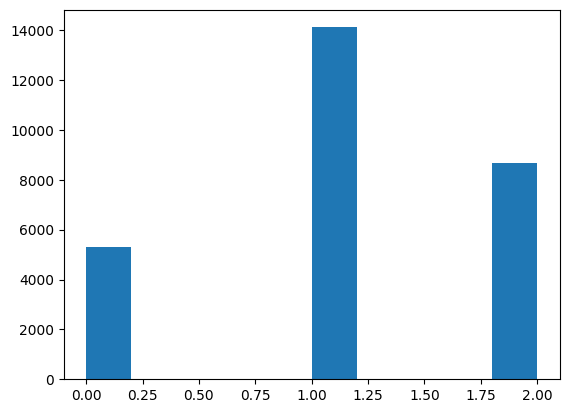

In [117]:
plt.hist(df['label'])

In [55]:
df['label'] =df['label'].replace({'negative':0, 'neutral':1, 'positive':2})
df['label'].unique()

array([1, 2, 0])

<function matplotlib.pyplot.show(close=None, block=None)>

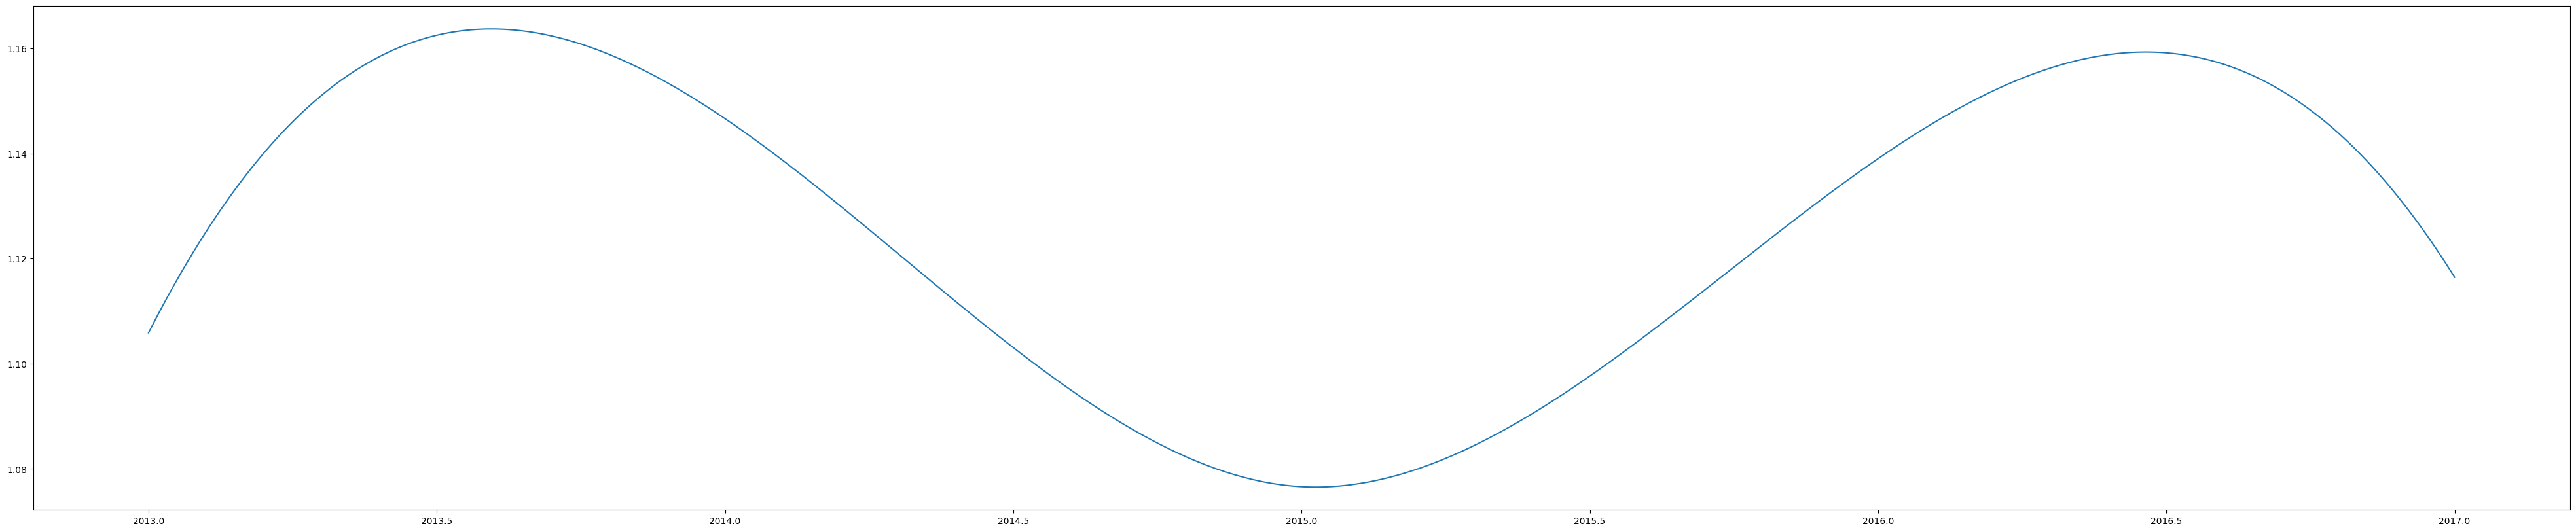

In [116]:
from scipy.interpolate import make_interp_spline
X_Y_Spline = make_interp_spline(y, m)
X_ = np.linspace(y.min(), y.max(), 500)
Y_ = X_Y_Spline(X_)
plt.figure(figsize = (50,10))
plt.plot(X_,Y_)
plt.show